In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2021/train.csv
/kaggle/input/tabular-playground-series-aug-2021/test.csv


In [6]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

In [7]:
import optuna # designed for automatic hyperparameter tuning

In [8]:
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss, mean_squared_error

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


### Reading data

In [9]:
train_df = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')

test_df = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')

SAM = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

### Summary of data

In [10]:
Summary = pd.DataFrame(train_df.dtypes)
Summary["isnull"] = train_df.isnull().sum()
Summary["max"] = train_df.max()
Summary["min"] = train_df.min()
Summary["isunique"] = train_df.nunique()
Summary["first"] = train_df.iloc[0]
Summary["second"] = train_df.iloc[1]
Summary["third"] = train_df.iloc[2]
pd.set_option('display.max_rows', None)
Summary

,0,isnull,max,min,isunique,first,second,third
id,int64,0,2.499990e+05,0.000000e+00,250000,0.000000e+00,1.000000e+00,2.000000e+00
f0,float64,0,1.072070e+00,-6.927340e-02,223000,-2.349810e-03,7.844620e-01,3.178160e-01
f1,int64,0,2.730000e+02,-1.700000e+01,289,5.900000e+01,1.450000e+02,1.900000e+01
f2,float64,0,9.768590e+00,-7.895580e+00,232906,7.667390e-01,-4.638450e-01,-4.325710e-01
f3,float64,0,1.680190e+00,-1.475560e+00,225458,-1.350460e+00,-5.304210e-01,-3.826440e-01
f4,float64,0,3.784750e+04,-7.589280e+03,235741,4.227270e+01,2.732490e+04,1.383260e+03
f5,float64,0,3.507800e+01,-3.291050e+00,212229,1.668570e+01,3.475450e+00,1.971290e+01
f6,float64,0,9.471430e+02,-4.096720e+01,226317,3.035990e+01,1.604980e+02,3.110260e+01
f7,float64,0,4.010380e+00,-4.143080e+00,222121,1.267300e+00,8.280070e-01,-5.153540e-01
f8,float64,0,4.659560e+02,-5.028130e+02,237743,3.920070e-01,3.735860e+00,3.443080e+01


### Creating Copy

In [11]:
train_df_c = train_df.copy()
test_df_c = test_df.copy()

columns = test_df_c.columns[1:]
display(columns)


Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60',
       'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70',
       'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80',
       'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90',
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99'],
      dtype='object')

### Distribution of target variable

<AxesSubplot:>

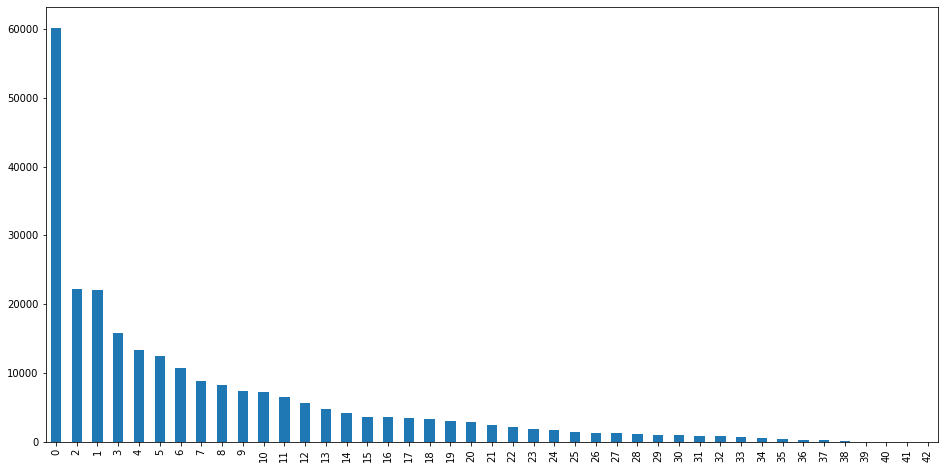

In [12]:
train_df_c['loss'].value_counts().plot(figsize=(16, 8), kind='bar')

### Dropping the Id and target variable from train data

In [13]:
X = train_df_c.drop(columns = ['id','loss']) # removing Id and loss columns
X.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60',
       'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70',
       'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80',
       'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90',
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99'],
      dtype='object')

In [14]:
y = train_df_c.loss # getting the target variable
# display(y)

In [15]:
display(y.min(), y.max())

0

42

### Dropping the Id from test data

In [16]:
XX = test_df_c.drop(columns = ['id']) # This is for test data

In [17]:
yc = y.copy() # This is for y
yc = np.clip(yc, 0, 1)# This divides data between 0 and 1 
# display(yc)

In [18]:
display(yc.min(), yc.max()) # Just for sanity check

0

1

<AxesSubplot:>

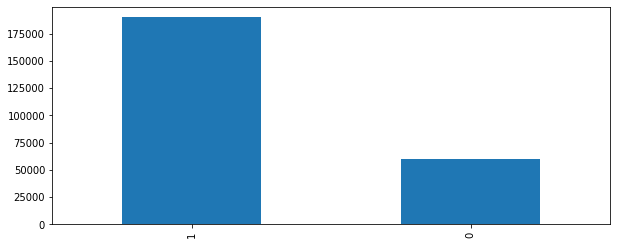

In [19]:
yc.value_counts().plot(figsize=(10, 4), kind='bar')

### Splitting the Data

In [20]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.50, random_state=123) #Splitting the data.
val_X.to_csv("val_X.csv",index=False)
val_y.to_csv("val_y.csv",index=False)

In [21]:
train_X, val_X, train_yc, val_yc = train_test_split(X, yc, test_size=0.50, random_state=123) 
#Splitting the data, yc has only values between 0 and 1.
val_yc.to_csv("val_yc.csv",index=False)

### Scaling the data, because the data has different ranges

In [22]:
from mlxtend.preprocessing import minmax_scaling # this is not sklearn
# This is before splitting the data
X_scaled = minmax_scaling(X, columns=X.columns) # Train_data

XX_scaled = minmax_scaling(XX, columns=XX.columns) # Test data

### Model

In [23]:
from xgboost import XGBRegressor
model1v = XGBRegressor(max_depth=7,
                       n_estimators=2500,
                       learning_rate=0.008,
                       subsample=0.84,
                       booster= 'gbtree',
                       tree_method= 'gpu_hist',
                       colsample_bytree= 0.70,
                       reg_lambda= 5,
                       reg_alpha= 32,
                       n_jobs= 4,  
                       alpha=0.5,
                       random_state=123)                                   

model1v.fit(train_X, train_y) # Fitting the model
oof_pred1 = model1v.predict(val_X) # predicting the test data
oof_pred1 = np.clip(oof_pred1, y.min(), y.max()) # making the between ymin and ymax

print(30 * '=')
print(f'Mean Error: {np.sqrt(mean_squared_error(val_y, oof_pred1))}')
print(30 * '=')

Mean Error: 7.845937362778934


In [24]:
model1v.feature_importances_

array([0.00793309, 0.00817526, 0.00904522, 0.00991075, 0.00866988,
       0.00886722, 0.00851345, 0.01012557, 0.00875931, 0.00919177,
       0.00855134, 0.00872874, 0.00905074, 0.01191851, 0.00941324,
       0.00894874, 0.00908251, 0.00958885, 0.00984224, 0.00937792,
       0.00939484, 0.00973898, 0.01004735, 0.0095897 , 0.00885224,
       0.01290979, 0.00921134, 0.00957941, 0.01160771, 0.009403  ,
       0.00943885, 0.01041084, 0.00948203, 0.00942053, 0.00952501,
       0.00943727, 0.00961652, 0.00999605, 0.00936909, 0.01081317,
       0.00948863, 0.01141103, 0.00917304, 0.00996813, 0.00979446,
       0.00951149, 0.0110946 , 0.00985303, 0.01099302, 0.00925514,
       0.01136805, 0.0105879 , 0.01366832, 0.01025182, 0.00938002,
       0.0100321 , 0.00954165, 0.01122415, 0.011243  , 0.00982376,
       0.00933048, 0.00967852, 0.00904836, 0.00989598, 0.01064035,
       0.01076569, 0.01116591, 0.00969543, 0.00927377, 0.01134652,
       0.01100207, 0.00938299, 0.00945225, 0.01068015, 0.01143

### Model to fit the whole data

In [25]:
model1 = XGBRegressor(max_depth=7,                     
                      n_estimators=2500,
                      learning_rate=0.008,
                      subsample=0.84,
                      booster= 'gbtree',
                      tree_method= 'gpu_hist',
                      colsample_bytree= 0.70,
                      reg_lambda= 5,
                      reg_alpha= 32,
                      n_jobs= 4,            
                      alpha=0.5,
                      random_state=123)   

model1.fit(X, y) # fitting on whole data
pred1 = model1.predict(XX) #fi
pred1 = np.clip(pred1, y.min(), y.max())
display(pred1, pred1.shape) 

array([7.5111513, 4.4534454, 8.081273 , ..., 6.053563 , 5.3487864,
       6.8806887], dtype=float32)

(150000,)

In [28]:
sub1 = SAM.copy()

sub1.iloc[:, 1] = pred1.data
# display(sub1)

In [27]:
sub1.to_csv("submission_xgb.csv",index=False)